In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import math
import numpy as np
import sklearn as sk

pd.options.display.max_columns = None
# Data Initialization
flood_df = pd.read_csv('data/flooding_events_augmented.csv', dtype=str, keep_default_na=False)
flood_df.head()

,YEAR,MONTH,BEGIN_DAY,BEGIN_TIME,BEGIN_LAT,BEGIN_LON,STATE,EVENT_TYPE,FLOOD_CAUSE,EVENT_NARRATIVE,temperature_2m_mean,wind_speed_10m_mean,cloud_cover_mean,relative_humidity_2m_mean,dew_point_2m_mean,precipitation_sum,rain_sum,snowfall_sum,pressure_msl_mean,soil_moisture_0_to_10cm_mean,elevation
0,2001,3,11,140,32.53333,-96.66667,TEXAS,Flash Flood,,Roads were closed near Sanger due to high water.,18.33104,21.042433,0.0,39.388832,4.5288677,0.0,0.0,0.0,1001.2181,0.4326143,146.0
1,2001,5,4,15,33.73333,-102.78333,TEXAS,Flash Flood,,I-27 was flooded and subsequently closed due t...,25.134928,22.688942,3.0631618,45.882435,12.775488,0.0,0.0,0.0,1007.633,0.110644,1150.0
2,2001,5,6,125,31.46667,-97.71667,TEXAS,Flash Flood,,Water was over Northwest Highway at Hillcrest ...,24.716516,13.942765,44.521587,68.5099,18.607435,0.0,0.0,0.0,1016.4537,0.3029499,265.0
3,2001,5,6,128,33.08333,-97.13333,TEXAS,Flash Flood,,Water was over Highway 75 at Parkview.,25.635132,12.174953,53.005688,65.30045,18.778494,0.0,0.0,0.0,1016.60834,0.19246636,190.0
4,2001,5,6,1700,33.36667,-97.68333,TEXAS,Flash Flood,,Flooding resulted in high water rescues and ma...,26.020544,9.831195,54.140934,63.18279,18.967064,0.0,0.0,0.0,1016.29364,0.18634742,280.0


In [6]:
# Robust missing detector (so blanks like "", "NA", "null" count as missing)
MISSING_TOKENS = {"", " ", "na", "n/a", "null", "none", "nan"}
def is_na_like(s):
    s = str(s).strip().lower()
    return s in MISSING_TOKENS

In [3]:
# Try to coerce known numeric columns; leave others as text
KNOWN_NUMERIC = [
    "YEAR", "MONTH", "BEGIN_DAY", "BEGIN_TIME", "BEGIN_LAT", "BEGIN_LON", "temperature_2m_mean", 
    "wind_speed_10m_mean", "cloud_cover_mean", "relative_humidity_2m_mean", "dew_point_2m_mean", 
    "precipitation_sum", "rain_sum", "snowfall_sum", "pressure_msl_mean", "soil_moisture_0_to_10cm_mean", 
    "elevation"
]
present_numeric = [c for c in KNOWN_NUMERIC if c in flood_df.columns]
def to_num(x):
    x = str(x).replace(",", "")
    try:
        return float(x)
    except:
        return np.nan
df_num = flood_df.copy()
for c in present_numeric:
    df_num[c] = df_num[c].apply(to_num)

In [7]:
miss_rows = []
for c in flood_df.columns:
    if c in present_numeric:
        miss = df_num[c].isna().sum()
    else:
        miss = flood_df[c].apply(is_na_like).sum()
    miss_rows.append({"column": c, "missing": int(miss), "missing_%": round(miss*100/len(flood_df), 2)})
miss_df = pd.DataFrame(miss_rows).sort_values("missing", ascending=False)
print("\n=== MISSING VALUES (robust) ===")
print(miss_df.to_string(index=False))


=== MISSING VALUES (robust) ===
                      column  missing  missing_%
                snowfall_sum      997      10.67
                    rain_sum      997      10.67
                 FLOOD_CAUSE      526       5.63
             EVENT_NARRATIVE       93       1.00
soil_moisture_0_to_10cm_mean       32       0.34
                        YEAR        0       0.00
            cloud_cover_mean        0       0.00
           pressure_msl_mean        0       0.00
           precipitation_sum        0       0.00
           dew_point_2m_mean        0       0.00
   relative_humidity_2m_mean        0       0.00
         temperature_2m_mean        0       0.00
         wind_speed_10m_mean        0       0.00
                       MONTH        0       0.00
                  EVENT_TYPE        0       0.00
                       STATE        0       0.00
                   BEGIN_LON        0       0.00
                   BEGIN_LAT        0       0.00
                  BEGIN_TIME        

In [8]:
print("=== DATA SHAPE & COLUMNS ===")
print(f"Rows: {len(flood_df):,}  |  Columns: {len(flood_df.columns)}")
print("Columns:", ", ".join(flood_df.columns))
print("\n=== HEAD(10) ===")
print(flood_df.head(10).to_string(index=False))
print("\n=== TAIL(5) ===")
print(flood_df.tail(5).to_string(index=False))

=== DATA SHAPE & COLUMNS ===
Rows: 9,340  |  Columns: 21
Columns: YEAR, MONTH, BEGIN_DAY, BEGIN_TIME, BEGIN_LAT, BEGIN_LON, STATE, EVENT_TYPE, FLOOD_CAUSE, EVENT_NARRATIVE, temperature_2m_mean, wind_speed_10m_mean, cloud_cover_mean, relative_humidity_2m_mean, dew_point_2m_mean, precipitation_sum, rain_sum, snowfall_sum, pressure_msl_mean, soil_moisture_0_to_10cm_mean, elevation

=== HEAD(10) ===
YEAR MONTH BEGIN_DAY BEGIN_TIME BEGIN_LAT  BEGIN_LON STATE  EVENT_TYPE FLOOD_CAUSE                                                                           EVENT_NARRATIVE temperature_2m_mean wind_speed_10m_mean cloud_cover_mean relative_humidity_2m_mean dew_point_2m_mean precipitation_sum   rain_sum snowfall_sum pressure_msl_mean soil_moisture_0_to_10cm_mean elevation
2001     3        11        140  32.53333  -96.66667 TEXAS Flash Flood                                                      Roads were closed near Sanger due to high water.            18.33104           21.042433              0.

In [9]:
if present_numeric:
    desc = df_num[present_numeric].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
    desc = desc.rename(columns={"50%":"median"}).reset_index().rename(columns={"index":"column"})
    print("\n=== NUMERIC STATS (describe) ===")
    print(desc.round(3).to_string(index=False))
else:
    print("\n(No numeric columns found to describe.)")


=== NUMERIC STATS (describe) ===
                      column  count     mean     std      min       1%       5%      25%   median      75%      95%      99%      max
                        YEAR 9340.0 2014.298   5.945 2001.000 2004.000 2005.000 2009.000 2015.000 2019.000 2024.000 2025.000 2025.000
                       MONTH 9340.0    6.375   2.458    1.000    1.000    3.000    5.000    6.000    8.000   10.000   12.000   12.000
                   BEGIN_DAY 9340.0   16.600   8.940    1.000    1.000    2.000    9.000   17.000   25.000   30.000   31.000   31.000
                  BEGIN_TIME 9340.0 1227.021 664.690    0.000    0.000  115.000  700.000 1252.500 1813.000 2220.000 2331.000 2359.000
                   BEGIN_LAT 9340.0   31.183   2.019   25.818   26.161   27.670   29.780   31.407   32.702   34.065   35.428   36.464
                   BEGIN_LON 9340.0  -98.083   2.497 -106.636 -105.876 -102.379  -99.550  -97.732  -96.426  -94.410  -93.950  -93.219
         temperature_2m_mean


=== CATEGORICAL STATS (describe for object) ===
         EVENT_TYPE
count          9340
unique            2
top     Flash Flood
freq           8022

=== CATEGORICAL VALUE COUNTS (top 20 each) ===
----------------------------------------------------------------------------------------------------
EVENT_TYPE | distinct=2 | top 20 shown
      value  count  percent
Flash Flood   8022    85.89
      Flood   1318    14.11


/var/folders/sr/wl072k0j639gxnqc7g60nk0h0000gn/T/ipykernel_96271/2836725499.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


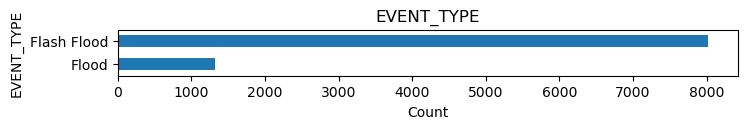

In [11]:
cat_cols = ["EVENT_TYPE"]

if cat_cols:
    print("\n=== CATEGORICAL STATS (describe for object) ===")
    print(flood_df[cat_cols].describe(include=['object']).to_string())
    print("\n=== CATEGORICAL VALUE COUNTS (top 20 each) ===")
    for col in cat_cols:
        s = flood_df[col].astype(str)
        s = s.where(~s.apply(is_na_like), "<MISSING>")
        vc = s.value_counts(dropna=False)
        top = vc.head(20)
        print("-"*100)
        print(f"{col} | distinct={vc.shape[0]} | top 20 shown")
        print(pd.DataFrame({"value": top.index, "count": top.values, "percent": (top.values/len(s)*100).round(2)}).to_string(index=False))
        ax = top.sort_values(ascending=True).plot.barh(figsize=(8, 0.3*len(top)), title=col)
        ax.set_xlabel("Count")
        plt.tight_layout()
        plt.show()
else:
    print("\n(No categorical columns detected under current rules.)")

In [13]:
def explore_numeric(col, data=df_num, bins=50):
    if col not in data.columns:
        print(f"{col} not found"); return
    s = pd.to_numeric(data[col], errors="coerce").dropna()
    if s.empty:
        print(f"{col}: no numeric data"); return
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    fig.suptitle(col)
    axes[0].hist(s, bins=bins); axes[0].set_title("Histogram"); axes[0].grid(True, alpha=0.3)
    axes[1].boxplot(s, vert=True, showfliers=True); axes[1].set_title("Boxplot"); axes[1].grid(True, axis="y", alpha=0.3)
    plt.tight_layout(); plt.show()
    print(s.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).round(3))

def visualize_categorical(col, data=flood_df, top_n=30):
    if col not in data.columns:
        print(f"{col} not found"); return
    s_raw = data[col].astype(str)
    s = s_raw.where(~s_raw.apply(is_na_like), "<MISSING>")
    vc = s.value_counts()
    print(f"{col} | distinct={vc.shape[0]} | total={len(s)} | missing={(s=='<MISSING>').sum()}")
    show = vc.head(top_n)
    print(pd.DataFrame({
        "value": show.index,
        "count": show.values,
        "percent": (show.values/len(s)*100).round(2)
    }).to_string(index=False))
    ax = show.sort_values(ascending=True).plot.barh(figsize=(8, 0.3*len(show)), title=col)
    ax.set_xlabel("Count"); plt.tight_layout(); plt.show()

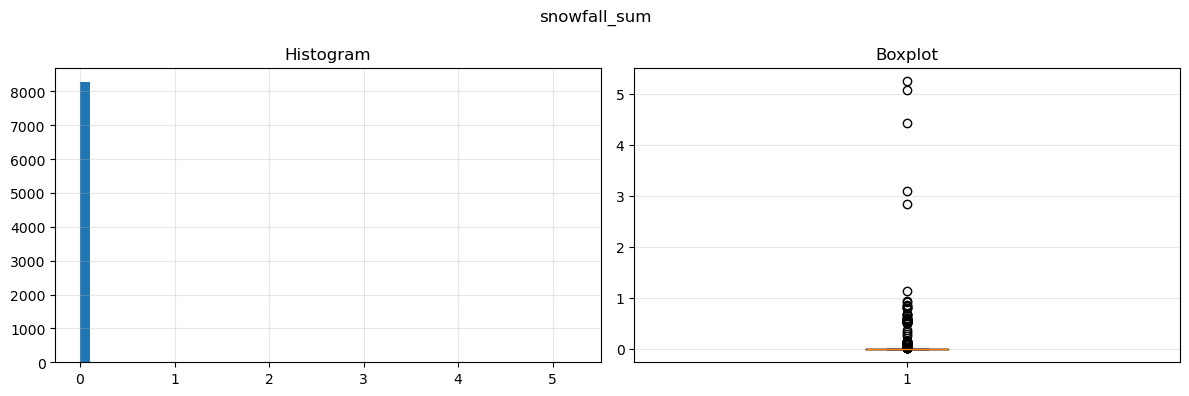

count    8343.000
mean        0.006
std         0.114
min         0.000
1%          0.000
5%          0.000
25%         0.000
50%         0.000
75%         0.000
95%         0.000
99%         0.000
max         5.247
Name: snowfall_sum, dtype: float64


In [14]:
explore_numeric("snowfall_sum")

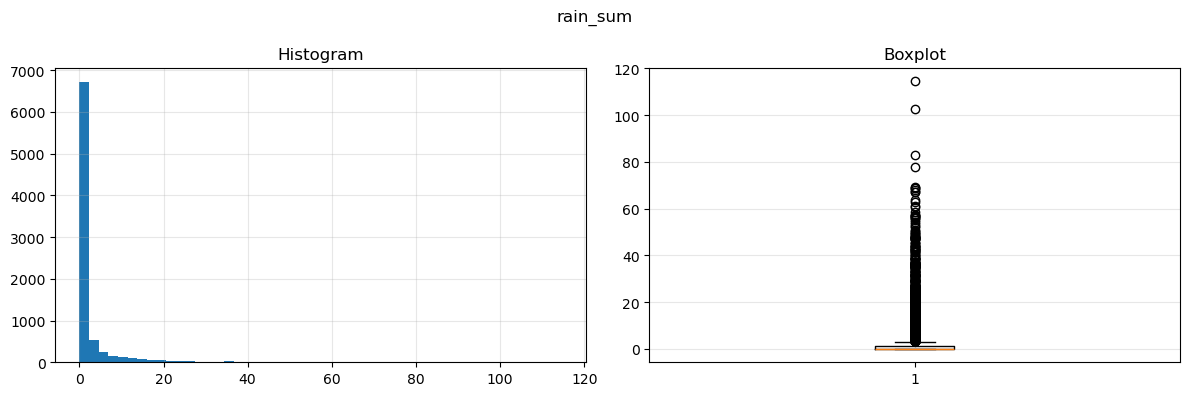

count    8343.000
mean        2.501
std         7.082
min         0.000
1%          0.000
5%          0.000
25%         0.000
50%         0.000
75%         1.261
95%        14.487
99%        36.113
max       114.628
Name: rain_sum, dtype: float64


In [15]:
explore_numeric("rain_sum")

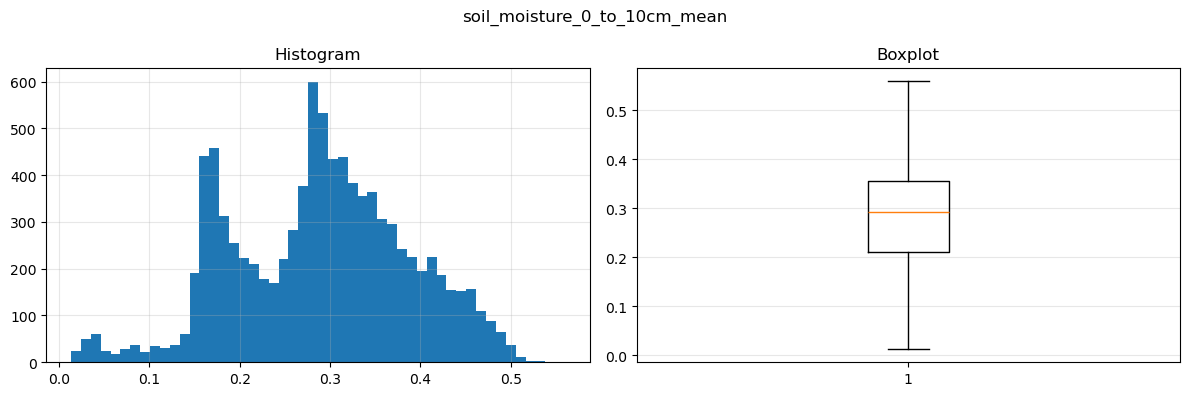

count    9308.000
mean        0.289
std         0.098
min         0.013
1%          0.039
5%          0.148
25%         0.212
50%         0.293
75%         0.357
95%         0.451
99%         0.487
max         0.560
Name: soil_moisture_0_to_10cm_mean, dtype: float64


In [16]:
explore_numeric("soil_moisture_0_to_10cm_mean")